In [1]:
import sys
import os
sys.path.insert(0, "../../python")
sys.path.insert(0, "../../litos")

import numpy as np
import particle_beam as pb
import plasma_source as ps
import particle_beam_propagation as pbp
import scipy.constants as const

import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
import beam.calc.electron as ecalc
import scipy.constants as const

import matplotlib.mlab as mlab
import nat_consts as nc
import particle_beam as pb
import plasma_source as ps
import particle_beam_propagation as pbp
import mike_math as mm
from   calc_M import calc_M
import scipy.stats as stats
import scipy.optimize as opt
from collections import defaultdict
import beam_ana as ba
import scipy.spatial as spatial
from matplotlib.ticker import FormatStrFormatter

path = '/mnt/md0/Data/Plots/PRL_Fig1/'

In [2]:
# define plasma bulk (flat-top) properties
npl0   = 5e16                      # cm^-3, plasma density
dEds0  = np.sqrt(npl0/(5e16))*16.67e9  # eV/m, energy gain rate
dgds0  = dEds0/nc.me               # 1/m, energy gain rate for rel. gamma
L_ft   = 0.50                      # m, length of flat-top
    
# define plasma up-ramp
shape_up = 'gauss' # shape of ramp
hw_up    = 0.1403  # m, half-width of ramp
L_up     = 1.0 # m, full length of ramp
top_up   = L_up    # m, relative location of ramp top
    
# define plasma down-ramp
shape_dn = shape_up # shape of ramp
hw_dn    = hw_up    # m, half-width of ramp
L_dn     = L_up     # m, full length of ramp
top_dn   = 0        # m, relative location of ramp top
    
# define beam parameters
npart  = 1000000   # number of macro particles
dist   = 'gauss' # distribution shape in trace space
gbC    = (10e9)/nc.me   # centroid relativistic lorentz factor
dgb    = 0.01    # relative energy spread (HWHM)
dz     = 0       # spread in z (HWHM)
eps    = 5.0e-6  # m-rad, normalized emittance
beta   = 0.10    # m, Twiss at vac. waist
alpha  = 0.00    # Twiss at vac. waist
gamma  = (1.0+alpha**2)/beta # 1/m, Twiss at vac. waist
    
# calculate betatron wave number in flat-top
wp0    = (5.64e4)*np.sqrt(npl0) # rad/s, plasma ang. freq. (flat-top)
kp0    = wp0/nc.c               # 1/m, plasma wave number (flat-top)
kb     = kp0/np.sqrt(2*gbC)     # 1/m, betatron wave number (flat-top)

# make beam at vac. waist
s0     = 0.0 # m
twiss  = pb.make_twiss(beta,alpha,gamma,eps,gbC,dgb,dz)
parts  = pb.make_parts(twiss[0],npart,dist)
ebeam  = pb.make_ebeam(s0,twiss[0],parts[0])
    
# set beam waist position
waist = -0.3884        # m, waist location w.r.t L_up
s_w   = L_up + waist # m, absolute wasit location
    
# define longitudinal steps
ds   = (1.0/kb)*(1./10.)                  # m, step size
s_ft = np.linspace(0,L_ft,int(L_ft/ds+1)) # m, steps for flat-top
s_up = np.linspace(0,L_up,int(L_up/ds+1)) # m, steps for up-ramp
s_dn = np.linspace(0,L_dn,int(L_dn/ds+1)) # m, steps for down-ramp

# make plasma
bulk    = ps.make_bulk(s_ft,npl0,dgds0)
up_ramp = ps.make_ramp(s_up,'up',shape_up,hw_up,top_up,npl0,dgds0)
dn_ramp = ps.make_ramp(s_dn,'dn',shape_dn,hw_dn,top_dn,npl0,dgds0)
plasma  = ps.make_plasma(bulk,up_ramp,dn_ramp) # output: plasma dict.

Nz: 5311
dgds0: 32622.3091977


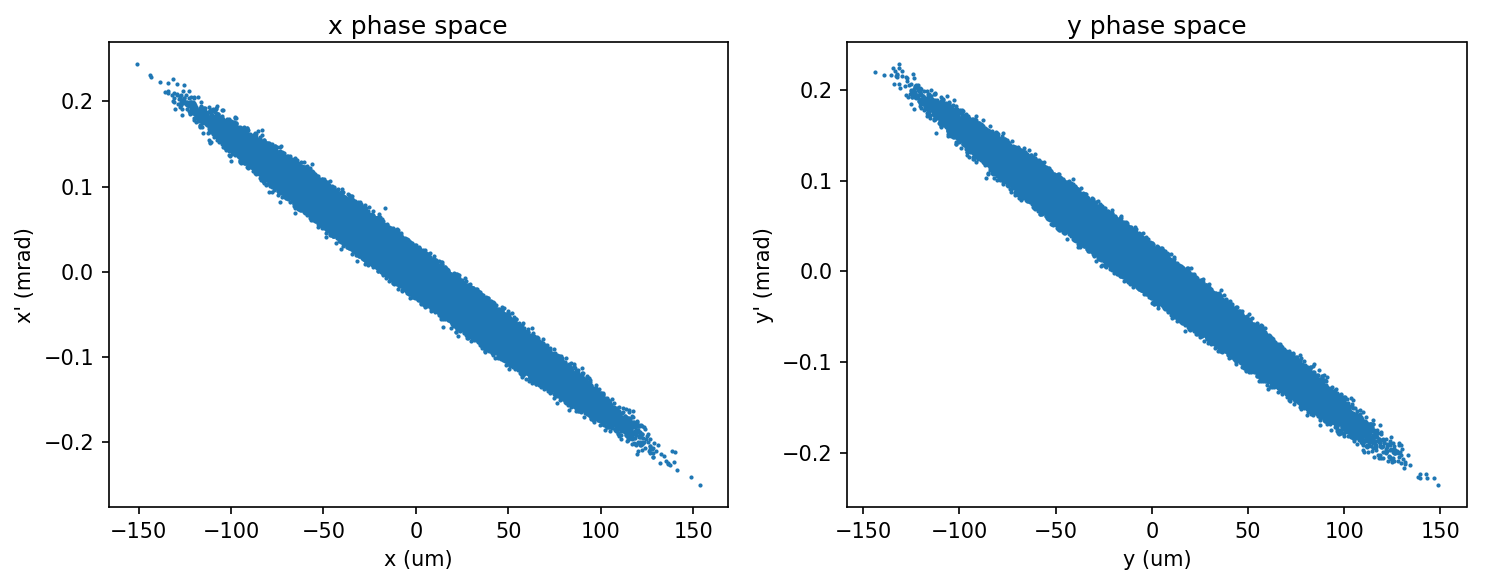

In [3]:
s = plasma['s']
z = s*1e6
ne = plasma['npl']/1e17
Nz = len(z)
print('Nz:', Nz)
print('dgds0:', dgds0)
# Now we can test my code and see if it is different
betaBeam = beta+(-s_w)**2/beta
alphaBeam = s_w/beta
electronParams = {
    'name' : '5e16',
    'path' : path,
    'load' : False,
    'N' : npart,
    'gamma' : gbC,
    'emittance' : eps,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : dgb
}

beam = electronbeam.GaussianElectronBeam(electronParams)
#beam = electronbeam.ElectronBeam(electronParams)
beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return ne
    def dgammadz(self, ne):
        npl = ne*1e17
        dgdz = dgds0*np.sqrt(npl/npl0)*(2*np.sqrt(npl/npl0)-1)
        return dgdz
    
plasmaDen = plasmaCls()
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 20)
beta, alpha, gamma, gb = ecalc.cs_propagation(z*1e-6, ne, betaBeam, alphaBeam, gbC, dgds0, npl0/1e17)

In [4]:
# Handle the dump periodicity
m = int(Nz/dumpPer)
beam_z = np.linspace(0.0, z[-1], m)*1e-6
dz = z[-1]/(m-1)
beam_ne = ne[::dumpPer]
beam_gb = gb[::dumpPer]

In [5]:
rms_x = np.zeros(m)
rms_x_eps = np.zeros(m)
un_kurt = np.zeros(m)
J_kurt  = np.zeros(m)
rms_beta = np.zeros(m)

frac = 1.0

for i in range(0, m):
    ptcls = beam.load_ptcls(i)[0]
    ebeam_rms = beam.get_beam_properties(i)
    rms_x[i]     = ebeam_rms["x"]/(1e-6)
    rms_x_eps[i] = ebeam_rms["x_eps"]/(1e-6)
    
    [u,v] = ba.real2norm_coords(beam.get_x(ptcls),beam.get_xp(ptcls),\
                                ebeam_rms["x_beta"],ebeam_rms["x_alpha"])
    J = (u**2+v**2)/2
    phi = np.arctan2(v,u)
    un = np.sqrt(2*J*beam_gb[i])*np.cos(phi)/np.sqrt(rms_x_eps[i])
    un_kurt[i] = stats.kurtosis(un,0,True)
    J_kurt[i] = stats.kurtosis(J,0,False,True)
    
    
i_flat_start = np.argwhere(plasma["s"]>=plasma["up_ramp"]["top_loc"])[0][0]

Tbeta   = beta[i_flat_start]
Talpha  = alpha[i_flat_start]
Tgamma  = gamma[i_flat_start]
TgbC    = gb[i_flat_start]
Twp0    = (5.64e4)*np.sqrt(plasma["bulk"]["npl0"]) # rad/s, plasma ang. freq.
Tkp0    = Twp0/nc.c # m^-1, plasma wave number
Tkb     = Tkp0/np.sqrt(2*TgbC)
Tbeta_m = 1.0/Tkb
TTbeam  = [Tbeta,Talpha,Tgamma]
TTmatch = [Tbeta_m,0,1.0/Tbeta_m]

BB      = ba.calc_Bmag(TTbeam,TTmatch)
print('Bmag: ',BB)
ent_z_v = s[0]+alpha[0]/gamma[0]
ent_beta_v = (1/gamma[0])/(1e-2)
exit_z_v = s[-1]+alpha[-1]/gamma[-1]
exit_beta_v = (1/gamma[-1])/(1e-2)

../../python/beam/beams/electronbeam.py:190: RuntimeWarning: invalid value encountered in sqrt
  prop['xxp']     = np.sqrt(sigmaxxp)


Bmag:  1.00005189548


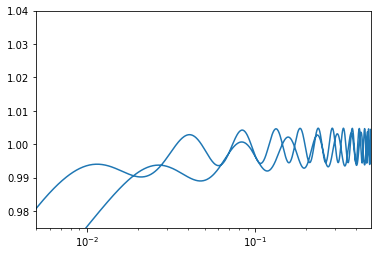

In [6]:
eps0 = const.physical_constants['electric constant'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
c = const.physical_constants['speed of light in vacuum'][0]
sigmaM = np.sqrt(c*np.sqrt(me*eps0/beam_ne/1e23/e**2)*1e6*np.sqrt(2*np.array(beam_gb))*5.0/np.array(beam_gb))
plt.plot(beam_ne, rms_x/sigmaM)
plt.xscale('log')
plt.xlim(0.005, 0.49)
plt.ylim(0.975, 1.04)
plt.show()

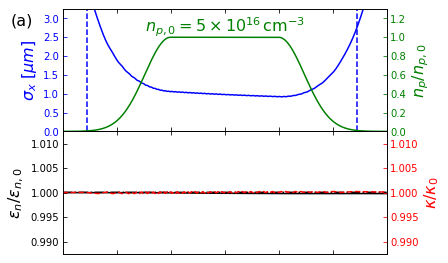

In [7]:
# which subfigure?
subfig = 'a'
#subfig = 'b'

figA, (ax1, ax3) = plt.subplots(2, sharex=True, sharey=False)

ax1.plot(beam_z,rms_x,color='b',linestyle='solid')
ax1.set_ylabel(r'$\sigma_x$ [$\mu m$]',color='b',fontsize=16)
ax1.tick_params('y',colors='b')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.set_ylim([0,3.25])
ax1.set_xlim([0.5,2.0])

ax1.plot([ent_z_v,ent_z_v],[0,6.5],color='b',linestyle='dashed')
ax1.plot([exit_z_v,exit_z_v],[0,6.5],color='b',linestyle='dashed')

ax1.yaxis.set_ticks(np.arange(0.0, 3.5, 0.5))

# subfigure label
if subfig=='a':
    #ax1.text(0.2, 0.85, r'(a)',
    ax1.text(-0.125, 0.9, r'(a)',
        verticalalignment='center', horizontalalignment='center',
        transform=ax1.transAxes,
        color='black', fontsize=16)
elif subfig=='b':
    ax1.text(0.20, 0.85, r'(b)',
        verticalalignment='center', horizontalalignment='center',
        transform=ax1.transAxes,
        color='black', fontsize=16)

npl = plasma["npl"]/plasma["bulk"]["npl0"]
ax2  = ax1.twinx()
ax2.plot(s,npl,color='g',linestyle='solid')
ax2.set_ylabel(r'$n_p/n_{p,0}$',color='g',fontsize=16)
ax2.tick_params('y',colors='g')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.set_ylim([0,1.3])
ax2.set_xlim([0.5,2.0])

ax2.yaxis.set_ticks(np.arange(0.0, 1.4, 0.2))

# plasma density text
if subfig=='a':
    ax2.text(0.50, 0.85, r'$n_{p,0} = 5\times 10^{16} \,{\rm cm^{-3}}$',
        verticalalignment='center', horizontalalignment='center',
        transform=ax2.transAxes,
        color='green', fontsize=16)
elif subfig=='b':
    ax2.text(0.50, 0.85, r'$n_{p,0} = 1\times 10^{18} \,{\rm cm^{-3}}$',
        verticalalignment='center', horizontalalignment='center',
        transform=ax2.transAxes,
        color='green', fontsize=16)
else:
    ax2.text(0.50, 0.85, \
             r'$n_{p,0} = %2.1e \,{\rm cm^{-3}}$'%plasma["bulk"]["npl0"],
        verticalalignment='center', horizontalalignment='center',
        transform=ax2.transAxes,
        color='green', fontsize=16)
    
ax3.plot(beam_z,rms_x_eps/rms_x_eps[0],color='k',linestyle='-')
ax3.plot(s,BB*np.ones(len(s)),color='k',linestyle='-.')
ax3.set_ylabel(r'$\varepsilon_n/\varepsilon_{n,0}$',color='k',fontsize=16)
ax3.tick_params('y',colors='k')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
if subfig=='a':
    ax3.set_ylim([0.9875,1.0125]) # matched limits
    ax3.yaxis.set_ticks(np.arange(0.990, 1.010, 0.005))
elif subfig=='b':
    ax3.set_ylim([0.9,1.9]) # mismatched limits
    ax3.yaxis.set_ticks(np.arange(1.0, 2.0, 0.2))
else:
    ax3.set_ylim([0.9,1.9])
ax3.set_xlim([0.5,2.0])

ax4 = ax3.twinx()
ax4.plot(beam_z,J_kurt/J_kurt[0],color='r',linestyle='--')
ax4.set_ylabel(r'$\kappa/\kappa_{0}$',color='r',fontsize=16)
ax4.tick_params('y',colors='r')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
if subfig=='a':
    ax4.set_ylim([0.9875,1.0125]) # matched limits
    ax4.yaxis.set_ticks(np.arange(0.990, 1.010, 0.005))
elif subfig=='b':
    ax4.set_ylim([0.9,1.9]) # mismatched limits
    ax4.yaxis.set_ticks(np.arange(1.0, 2.0, 0.2))
else:
    ax4.set_ylim([0.9,1.9])
ax4.set_xlim([0.5,2.0])

ax1.tick_params(top=True,bottom=True,left=True,direction='in',length=4)
ax2.tick_params(direction='in',length=4)
ax3.tick_params(top=True,bottom=True,left=True,direction='in',length=4)
ax4.tick_params(direction='in',length=4)

xlabel_locs = [0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0]
if subfig=='a':
    xlabels = []
elif subfig=='b':
    xlabels = [0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5]
else:
    xlabels = [0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5]
plt.xticks(xlabel_locs, xlabels)

if subfig=='a':
    ax3.set_xlabel('',fontsize=16)
elif subfig=='b':
    ax3.set_xlabel('z [m]',fontsize=16)
else:
    ax3.set_xlabel('z [m]',fontsize=16)

# copy and past these two lines into console to remove
# x-axis title and tick marks after initial plot is made
#ax3.set_xlabel('',fontsize=16) # remove x-axis label
#ax3.get_xaxis().set_ticks([]) # remove x-axis ticks

# I know it appears redundant, but keep these here!
ax1.set_xlim([0.5,2.0])
ax3.set_xlim([0.5,2.0])

ax1.set_position([0.125,0.550,0.75,0.425])
ax2.set_position([0.125,0.550,0.75,0.425])
ax3.set_position([0.125,0.125,0.75,0.425])
ax4.set_position([0.125,0.125,0.75,0.425])

#figA.tight_layout()
#figA.subplots_adjust(hspace=0)
plt.savefig(path+'PRL_Fig1_aOutside.eps', format='eps')
plt.savefig(path+'PRL_Fig1_aOutside.png', format='png', dpi=900)
plt.show()

In [10]:
print('Initial Kurtosis: ', J_kurt[0])
print('Initial Emittance: ', rms_x_eps[0])
print('Final Kurtosis: ', J_kurt[-1])
print('Final Emittance: ', rms_x_eps[-1])

Initial Kurtosis:  9.09144757937
Initial Emittance:  4.99275253784
Final Kurtosis:  9.09246897087
Final Emittance:  4.99172237571
